In [11]:
from __future__ import print_function
import librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
samples_per_chunk = 300
num_chunks_per_slice = 65
num_chunks_per_beat = 8

In [13]:
filename = "song.ogg"

In [14]:
y, sr = librosa.load(filename)

In [5]:
#plt.plot(range(len(y)),y)

In [6]:
length = librosa.get_duration(y=y,sr=sr)

In [7]:
tempo = np.round(librosa.beat.tempo(y, sr=sr))
new_sample_rate = (tempo/200)*8000
y = librosa.resample(y, sr, new_sample_rate)

In [8]:
tempo

array([136.])

In [9]:
def chunks(l, n): #Yield successive n-sized chunks from l
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [10]:
#This function takes an int representing the BPM, a float representing how long the song is in secs, and
#a long int representing the file size. This information is used to create a list containing the start 
#and endpoints for blocks.

def blockList(BPM, secs, fileSize,y):
    mins = secs / 60.0 #how many minutes long is the song
    numBeats = int(BPM * mins) #the number of beats in the song
    numChunks = numBeats * 8 #the total number of chunks
    chunkSize = int(fileSize / numChunks) #how many points there are in a chunk

    chunker = chunks(y, int(chunkSize))
    List = [np.abs(np.fft.fft(next(chunker)))[0:int(chunkSize/2)+1] for i in range(int(numChunks))]

    print("minutes   :", mins)
    print("num beats :", numBeats)
    print("num chunks:", numChunks)
    print("chunk size:", chunkSize)        
    
    return List, numChunks, numBeats
    

In [24]:
chunkedList, number_of_chunks, number_of_beats = blockList(tempo, length, len(y), y)

minutes   : 3.7839092970521544
num beats : 514
num chunks: 4112
chunk size: 300


In [25]:
def sliding_window_gen(l, noc, ncps): #parameters: the list of numpy arrays, the number of chunks, and the number of chunks per slice
    for i in range(int(ncps/2)): #pad both sides of the input list with numpy arrays of zeros 
        l.insert(0, np.zeros(int(samples_per_chunk/2)+1))
        l.append(np.zeros(int(samples_per_chunk/2)+1))
    for j in range(noc):
        yield np.concatenate(l[j:j+ncps])

In [26]:
window_generator = sliding_window_gen(chunkedList, number_of_chunks, num_chunks_per_slice)

In [27]:
current_window = np.zeros(shape=(number_of_chunks, int(((samples_per_chunk/2)+1)*num_chunks_per_slice)))
for i in range(number_of_chunks):
    current_window[i] = next(window_generator)

In [28]:
import json
import numpy as np
from sympy import *
init_printing(use_latex=True)
import scipy.spatial.distance as ssd
from pprint import pprint
    
def jsonInterpretor(filename, beats):
    
    with open(filename) as f:
        data = json.load(f)          
  
    notes = "_notes"
    time = "_time"
    lineIndex = "_lineIndex" #row
    lineLayer = "_lineLayer" #column
    types = "_type" #0 is one color and 1 is the other
    cutDirection = "_cutDirection"#9 cut directions

    MatrixRows = beats * num_chunks_per_beat

    FinalMatrix = np.zeros(shape=(MatrixRows,32))#will hold all of the vectors, should be 32 by the number of beats * 8

    j = 0; #index for .json notes
    beat = 0.0 #1/8 increments for keeping track of time
    num_index_choices = 4 #the highest value for lineIndex + 1
    num_layer_choices = 3
    num_direction_choices = 9
        
    for n in range(len(data[notes])):
        row = int(np.round(data[notes][n][time]*num_chunks_per_beat)) #round to nearest 1/8th second
        if data[notes][n][types] < 2:
            FinalMatrix[row][ data[notes][n][lineIndex] + data[notes][n][types]*16 ] = 1
            FinalMatrix[row][data[notes][n][lineLayer] + num_index_choices + data[notes][n][types]*16] = 1
            FinalMatrix[row][data[notes][n][cutDirection] + num_index_choices + num_layer_choices + data[notes][n][types]*16] = 1
    
    return FinalMatrix;



In [29]:
A = jsonInterpretor('Hard.json', number_of_beats)
def beatmap_training_gen(A): #slice matrix into its rows
    for i in range(len(A)):
        yield A[i:(i+1)]

In [30]:
beatmap_training_generator = beatmap_training_gen(A)

In [31]:
#for i in range(163):
#    next(beatmap_training_generator)

In [32]:
next(beatmap_training_generator)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
import dill
sessionfilename = "session-" + str(samples_per_chunk) + "-" + str(num_chunks_per_slice) + "-" + str(num_chunks_per_beat) + ".pkl"
print(sessionfilename)
dump_session(filename=sessionfilename, main=None, byref=False)

session-300-65-8.pkl


In [40]:
import keras

from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

from sympy import *
init_printing(use_latex=True)

model = keras.models.Sequential()
model.add(keras.layers.Dense(512,input_dim=(int((samples_per_chunk/2+1)*num_chunks_per_slice)),activation='relu', bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.Dense(32,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               5025792   
_________________________________________________________________
dense_6 (Dense)              (None, 32)                16416     
Total params: 5,042,208
Trainable params: 5,042,208
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
#window size of 1. 
history = model.fit(current_window, A,
    batch_size=400,epochs=150,verbose=1)

Epoch 1/150
4112/4112 [==============================] - 6s 1ms/step - loss: 0.4460
Epoch 2/150
4112/4112 [==============================] - 3s 782us/step - loss: 0.1766
Epoch 3/150
4112/4112 [==============================] - 7s 2ms/step - loss: 0.1762
Epoch 4/150
4112/4112 [==============================] - 9s 2ms/step - loss: 0.1760
Epoch 5/150
4112/4112 [==============================] - 8s 2ms/step - loss: 0.1759
Epoch 6/150
4112/4112 [==============================] - 6s 1ms/step - loss: 0.1758
Epoch 7/150
4112/4112 [==============================] - 7s 2ms/step - loss: 0.1758
Epoch 8/150
4112/4112 [==============================] - 9s 2ms/step - loss: 0.1757
Epoch 9/150
4112/4112 [==============================] - 9s 2ms/step - loss: 0.1756
Epoch 10/150
4112/4112 [==============================] - 9s 2ms/step - loss: 0.1755
Epoch 11/150
4112/4112 [==============================] - 10s 2ms/step - loss: 0.1754
Epoch 12/150
1600/4112 [==========>...................] - ETA: 5s - los

KeyboardInterrupt: 

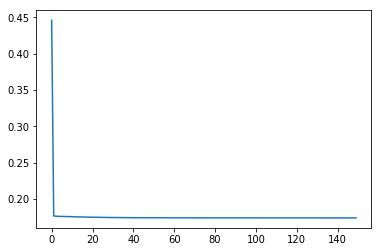

In [26]:
plt.plot(history.history['loss'])

In [28]:
score = model.evaluate(current_window, A, verbose=1)
print('Test loss:', score)

4112/4112 [==============================] - 1s 220us/step
Test loss: 0.046837326625697874


In [29]:
output = model.predict(current_window, verbose=1)

4112/4112 [==============================] - 1s 171us/step


In [37]:
#np.savetxt("out2.txt", (np.round(output)).astype(int))
np.savetxt("out2.txt", np.round(output), "%d")